### Neural Net with TensorFlow

In [ ]:
# Install tensorflow and protobuf -- run once!
# anaconda install instructions: https://www.tensorflow.org/install/install_mac

# # For chase's macbook, the following shell commands worked (take out ! if in terminal)
# !conda create -n tensorflow python=2.7
# !source activate tensorflow
# !pip install --ignore-installed --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.4.0-py2-none-any.whl

# Remember to activate container when you want to use package

In [105]:
!source activate tensorflow
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np



CondaEnvironmentNotFoundError: Could not find environment: tensorflow .
You can list all discoverable environments with `conda info --envs`.



In [76]:
# Import Dataset Pickle
import pickle
import pandas as pd
dfNN_raw = pickle.load(open('NN_pickles.p', 'rb'))
print dfNN_raw.head(5)
# pd.options.display.max_rows = len(dfNN_raw)
# dfNN_raw.head(len(dfNN_raw))


  prev_price next_price   pos    neg    neu compound
0     307.15     307.26  0.31      0   0.69   0.7424
1        463     467.29     0  0.209  0.791  -0.7003
2     465.01     461.57     0  0.253  0.747  -0.1759
3     464.53     465.01     0      0      1        0
4        462        465     0      0      1        0


In [1]:
# Python
# import tensorflow as tf
# hello = tf.constant('Hello, TensorFlow!')
# sess = tf.Session()
# print(sess.run(hello))

Hello, TensorFlow!


In [91]:
ddNN = (dfNN_raw - dfNN_raw.mean()) / (dfNN_raw.max() - dfNN_raw.min())
ddNN.reset_index(inplace=True)
del ddNN['index']
ddNN['next_price'] = ddNN['prev_price'].shift(-1)
ddNN.head(5)
print ddNN.head(5)

  prev_price next_price       pos       neg       neu   compound
0  -0.205992   0.468625   0.30568 -0.041533 -0.237517   0.342107
1   0.468625   0.477325 -0.110987  0.214909  -0.11359   -0.46241
2   0.477325   0.475247 -0.110987  0.268896 -0.167578   -0.16998
3   0.475247   0.464296 -0.110987 -0.041533  0.142851 -0.0718898
4   0.464296   0.477325 -0.110987 -0.041533  0.142851 -0.0718898


In [92]:
# Taking straight from LSTM Stock Model
num_epochs = 1000

batch_size = 1

total_series_length = len(dfNN.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 6437
The current configuration gives us 2145 batches of 1 observations each one looking 3 steps in the past


In [93]:
# Split Training-Test
dfTrain = dfNN[dfNN.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(dfNN.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(dfNN.index)-i
        break

dfTest =  dfNN[dfNN.index >= test_first_idx]

In [94]:
xTrain = dfTrain[['prev_price','neu','neg','pos']].as_matrix()[::-1]
yTrain = dfTrain['next_price'].as_matrix()[::-1]

In [95]:
xTrain.shape


(6435, 4)

In [96]:
xTest = dfTest[['prev_price','neu','neg','pos']].as_matrix()
yTest = dfTest['next_price'].as_matrix()

In [97]:
yTest.shape


(102,)

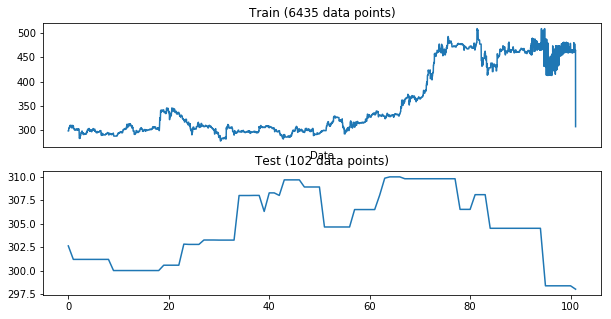

In [98]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig,ax = plt.subplots(2,1, figsize = (10,5))
ax[0].plot(xTrain[:,0])
ax[0].set_title('Train (' +str(len(xTrain))+' data points)')
ax[0].set_xlabel('Date')
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%y'))

ax[1].plot(xTest[:,0])
ax[1].set_title('Test (' +str(len(xTest))+' data points)')

# plt.figure(figsize=(25,5))
# plt.plot(xTrain[:,0])
# plt.title('Train (' +str(len(xTrain))+' data points)')
# plt.xaxis.set_major_locator(mdates.MonthLocator())
# plt.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%y'))

plt.show()

# plt.figure(figsize=(10,3))
# plt.plot(xTest[:,0])
# plt.title('Test (' +str(len(xTest))+' data points)')
# plt.show()

In [99]:
# LOAD DATA^

In [100]:
# SETUP NET

In [101]:
tf.reset_default_graph()


In [102]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

In [106]:
# irrelevant if no more classes (random array unif distribution) 
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

In [107]:
# unpack and create edge from input to hidden layer
labels_series = tf.unstack(batchY_placeholder, axis=1)


In [108]:
# forward pass
cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [109]:
# talk about permutations and how data goes through nodes
states_series = tf.transpose(states_series,[1,0,2])


In [110]:
# backwards pass starting point
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

In [111]:
# bp weights and biases
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

In [116]:
prediction = tf.matmul(last_state,weight) + bias
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))
train_step = tf.train.AdamOptimizer(learning_rate=0.000001).minimize(loss)


In [118]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    num_epochs = 1
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one
        
        print test_pred[-1][0]

Epoch 0
Step 0 - Loss: 88443.687500
Step 50 - Loss: 83397.726562
Step 100 - Loss: 89936.421875
Step 150 - Loss: 84317.945312
Step 200 - Loss: 83045.140625
Step 250 - Loss: 92660.953125
Step 300 - Loss: 87736.414062
Step 350 - Loss: 90103.304688
Step 400 - Loss: 114397.187500
Step 450 - Loss: 114966.132812
Step 500 - Loss: 103503.421875
Step 550 - Loss: 99590.421875
Step 600 - Loss: 94402.171875
Step 650 - Loss: 78200.109375
Step 700 - Loss: 87688.210938
Step 750 - Loss: 86659.820312
Step 800 - Loss: 86665.320312
Step 850 - Loss: 92664.406250
Step 900 - Loss: 84315.390625
Step 950 - Loss: 88964.054688
Step 1000 - Loss: 87603.171875
Step 1050 - Loss: 84448.468750
Step 1100 - Loss: 100328.359375
Step 1150 - Loss: 102652.656250
Step 1200 - Loss: 92504.546875
Step 1250 - Loss: 99184.109375
Step 1300 - Loss: 110684.281250
Step 1350 - Loss: 111437.734375
Step 1400 - Loss: 110085.765625
Step 1450 - Loss: 135696.187500
Step 1500 - Loss: 136351.875000
Step 1550 - Loss: 207175.656250
Step 1600 - 

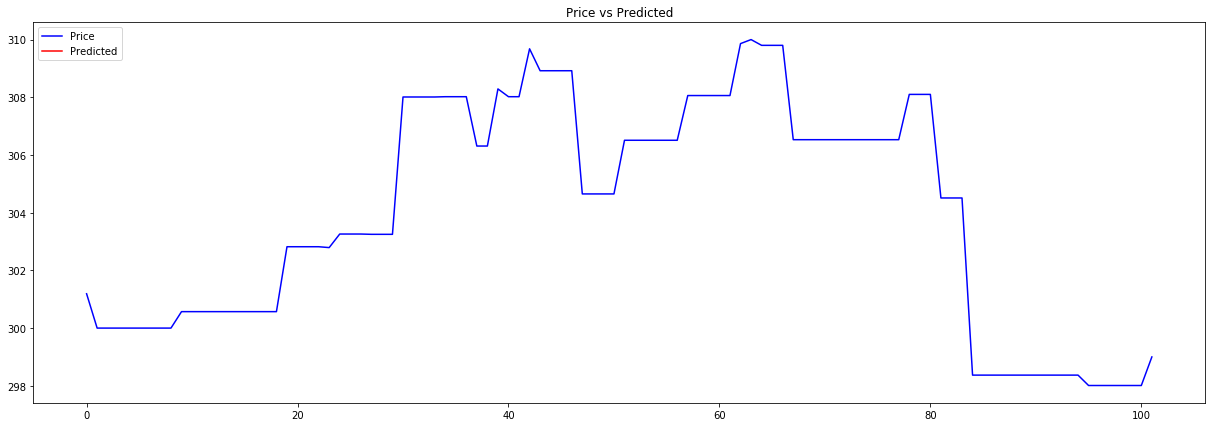

In [114]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()